<a href="https://colab.research.google.com/github/danakreimer/deep_learning/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning final project**



#### **Bar Ilan university, semester A, 2022**



#### **David Dorfman, Dana Kraimer**



First of all, download the datasets from the following link into your "MyDrive" folder: https://drive.google.com/file/d/18wEBdJhGKdkx6YbkdkYziJrXj4mMmkVV/view?usp=sharing

Then, download the model's pre-trained weights using the following link: https://drive.google.com/drive/folders/1xT9W0xU4UAwi3dIarLz3UEzylas4kYDZ?usp=sharing


To evaluate a photo, change the args_dict like so:
1. change 'only_evaluate' to True
2. change 'best_model_path' to the needed model (moent/photo) path ('./out/context_encoder_training/run_53' for ex)
3. change 'train_test_split_pct' to 0
4. change 'masking_mode' to 'mask_file'
5. put your mask file in the masks folder and put the name of the file in the variable 'mask_file': '<mask-filename>.png/jpg'
6. put the test images in a folder - ./data/test/test/
7. change 'dataset' to 'test'

To train a model, change the args_dict like so:
1. change 'only_evaluate' to False
2. change 'train_test_split_pct' to 8/10
3. change 'dataset' to be either 'Photo' or 'Monet'
to train a center model change 'masking_mode' to 'center'
to train a single mask file:
  * change 'masking_mode' to 'mask_file'
  * change 'mask_file' to the name of the specific mask in the masks folder
to train many random masks from a folder:
  * change 'masking_mode' to 'random_mask_file'
  * change 'random_masks_folder' to a folder name that has many mask images ('masks' or 'masks_photo' for ex)

how to run augmentations:
* change 'augment_to_size' to the required images count (7037 to generate new
augmented photos so that there are 7037 files in the folder)
* change 'augment_to_size' to None to prevent augmentation
* to change the amount of operations done in each augmentation, change 'augmentation_operations' to the required amount

A few important notes:
1. When testing the trained models over the test set it is not possible to use the same mask as the masks that were used while using the photo/Monet data-set. The masks that should be used are have to be masks that are specificly customized for the test set.
2. When the train process is being preformed, we recommend downloading the data-set and extracting it from the zip file using the second code cell below, even though you have the data-set saved on your Google Drive. The reason is that our project uses a specific format of repositories which is necessary for it to run smoothly. 
If you are not interested in performing the extraction process, we recommend to orgnize the data-set files in the following order:


* data

  ** monet_jpg

        *** monet_jpg
        - 0a0c3a6d07.jpg
        - 0a0d3e6ea7.jpg
        .
        .
        .

  ** photo_jpg

        *** photo_jpg
        - 0a0c3a6d07.jpg
        - 0a0d3e6ea7.jpg
        .
        .
        .

These are the results of running the test and validation sets:

https://drive.google.com/drive/folders/1MqHCvvsby1sE_wiUCIfvTvM5ejOy6sxP?usp=sharing

 **********************************************************************

We had an amazing experience working on this project and learned so much in the process, 

hope you enjoy the outcome! 

In [ ]:
import os
import sys
import json
import numpy as np
from argparse import Namespace
import random
import torch
import logging
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import torchvision.transforms.functional as tfF
from torch.utils.data import Sampler, WeightedRandomSampler, RandomSampler, Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Optimizer, Adam
import torch.nn as nn
from tqdm import tqdm
from typing import Dict, List, Union, Callable, Optional
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import matplotlib.pyplot as plt
from google.colab import drive

# Loading the data sets into google drive and initiallizing the logger

In [ ]:
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive')
!unzip "/content/drive/MyDrive/data.zip" -d "/content/drive/MyDrive/"
logger = logging.getLogger()

Mounted at /content/drive


# Model hyperparameters and settings

In [ ]:
args_dict = {
    'only_evaluate': True,  # True - runs best model on the dataset, False - trains & validates a model
    'best_model_path': '/content/drive/MyDrive/Deep Learning/models/model_photo',  # the path to the model when using only_evaluate
    'epochs': 50,  # num of epochs
    'train_test_split_pct': 0,  # how to split the dataset between train/test (set to 0 for all photos)
    'image_size': 128,  # the image size to resize to
    'masking_mode': 'mask_file',  # can be 'center', 'cubes', 'random', 'mask_file', 'random_mask_file'
    'mask_file': '1.jpeg_mask_central_block_.jpg',  # mask_randomRegion_1920.png',  # None for a random mask (masking_mode = mask_file)
    'random_masks_folder': 'masks',
    'mask_area': 0.25,  # the area of the mask for random generation (masking_mode = random)
    'dataset': 'test',  # data set name 'Photo' | 'Monet' | 'photo_test'
    'data_dir': '/content/drive/MyDrive/Project/data/',
    'show_graphs': False,
    'show_plots': True,
    'dataset_folder': None,  # none to inherit
    'batch_size': 64,  # the batch size
    'patch_loss': False,  # should use only the patch for loss or the entire image
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'augment_to_size': None,  # the amount of augmented images to create for each image
    'augmentation_operations': 1,
    'mask_color_dim1': 2 * 117.0 / 255.0 - 1.0,
    'mask_color_dim2': 2 * 104.0 / 255.0 - 1.0,
    'mask_color_dim3': 2 * 123.0 / 255.0 - 1.0,
    'num_validation': 1,
    'out_dir': '/content/drive/MyDrive/out',
    'beta1': 0.5,
    'beta2': 0.999,
    'bottleneck': 4000,
    'checkpoint_interval': 50,
    'ema_decay': 0.999,
    'initial_indices': None,
    'is_pct': False,
    'iters_per_epoch': 1024,
    'lr': 0.0002,
    'max_pattern_size': 10000,
    'num_workers': 0,
    'overlap': 0,
    'overlap_weight_multiplier': 10,
    'draw_progress_bar': True,
    'pin_memory': False,
    'polyaxon': False,
    'pretrained': False,
    'random_seed': False,
    'resolution': 0.03,
    'resume': '',
    'save': False,
    'seed': 65,
    'trainable_layers': [],
    'w_rec': 0.999,
    'weighted_sampling': False,
}

dataset_folders = {
    'Monet': 'monet_jpg',
    'Photo': 'photo_jpg'
}

args_dict['dataset_folder'] = dataset_folders[args_dict['dataset']] if args_dict['dataset'] in dataset_folders else f"{args_dict['dataset']}"
args_dict['mask_size'] = int(np.sqrt(args_dict['mask_area']) * args_dict['image_size'])
args_dict['random_masking'] = args_dict['masking_mode'] == 'random' or args_dict['masking_mode'] == 'mask_file' or args_dict['masking_mode'] == 'random_mask_file'
args = Namespace(**args_dict)
torch.device(args.device)


device(type='cuda')

# Dataset loader and custom subset classes

In [ ]:
class JPEGDataset(Dataset):
    def __init__(self,
                root: str,
                train: bool,
                transform: Optional[Callable] = None,
                target_transform: Optional[Callable] = None,
                download: bool = False,
                train_split_pct: float = args.train_test_split_pct,
                img_size: int = 128,
                dataset_folder: str = args.dataset_folder):
        self.root = root
        self.train = train
        self.train_split = train_split_pct
        self.data = []
        self.targets = []
        self.classes = []
        self.classes_to_idx = {}
        self.img_size = img_size
        self.dataset_folder = dataset_folder
        self.load_images()
        self.transform = transform
        self.target_transform = target_transform

    def load_images(self):
        base_path = os.path.join(self.root, self.dataset_folder)
        if not os.path.exists(base_path):
            raise RuntimeError("Dataset not found! Please place ensure data set is present at {}".format(base_path))
        self.classes = sorted(os.listdir(base_path))
        self.classes_to_idx = {image_class: idx for idx, image_class in enumerate(self.classes)}
        for image_class in self.classes:
            class_paths = list(
                map(
                    lambda x: os.path.join(base_path, image_class, x),
                    filter(
                        lambda x: x.endswith(".jpg"),
                        sorted(os.listdir(os.path.join(base_path, image_class))),
                    )
                )
            )
            split_idx = int(len(class_paths) * self.train_split)
            split_image_paths = class_paths[:split_idx] if self.train else class_paths[split_idx:]
            self.data.extend(split_image_paths)
            self.targets.extend(len(split_image_paths) * [self.classes_to_idx[image_class]])

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = transforms.Resize((self.img_size, self.img_size))(Image.open(img).convert("RGB"))
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target
    def __len__(self):
        return len(self.targets)


class CustomSubset(Dataset):
    def __init__(
            self,
            dataset: Dataset,
            indices: List,
            transform: Callable,
            return_index: bool = False,
    ):
        self.indices = indices
        self.dataset = dataset
        self.transform = transform
        try:
            self.targets = [self.dataset.targets[idx] for idx in self.indices]
        except AttributeError as ex:
            self.targets = []
        try:
            self.classes = dataset.classes
        except AttributeError as ex:
            self.classes = []
        self.return_index = return_index

    def __getitem__(self, idx: int):
        img, label = self.dataset[self.indices[idx]]
        if self.return_index:
            return self.transform(img), label, self.indices[idx]
        else:
            return self.transform(img), label

    def __len__(self):
        return len(self.indices)

    def update_subset_indices(self, new_indices: List):
        self.indices = new_indices
        self.targets = [self.dataset.targets[idx] for idx in self.indices]

# Program constants

In [ ]:
NORMALIZATION_VARIABLES = {
    "Photo": {
        "mean": (0.4914, 0.4822, 0.4465),
        "std": (0.2470, 0.2435, 0.2616)
    },
    "Monet": {
        "mean": (0.4914, 0.4822, 0.4465),
        "std": (0.2470, 0.2435, 0.2616)
    },
}

DEFAULT_NORMALIZATION_VARIABLES = {
        "mean": (0.4914, 0.4822, 0.4465),
        "std": (0.2470, 0.2435, 0.2616)
}

DATASET_GETTERS = {
    'Photo': JPEGDataset,
    'Monet': JPEGDataset
}

IMG_SIZE = {
    "Photo": 128,
    "Monet": 128,
}


# Initializint output directories

In [ ]:
def get_save_path():
    save_dir = os.path.join(args.out_dir, "context_encoder_training")
    os.makedirs(save_dir, exist_ok=True)
    images_dir = os.path.join(args.out_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    num_existing_dirs = len(os.listdir(save_dir))
    save_path = os.path.join(save_dir, "run_{}".format(num_existing_dirs))
    os.makedirs(save_path, exist_ok=True)
    return save_path

# Initializing logger and seed value

In [ ]:
def initialize_logger(save_path: str):
    logger = logging.getLogger()
    logging.basicConfig(filename=os.path.join(save_path, "log.log"),
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO)
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.INFO)
    logger.addHandler(console_handler)


def seed(random_seed: bool, seed: int):
    seed = random.randint(0, 100) if random_seed else seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    return seed

# Saving the hyperparameters and other settings

In [ ]:
def save_args(args, save_path: str):
    args_dict = vars(args)
    args_file_path = os.path.join(save_path, "args.json")
    with open(args_file_path, "w") as file:
        json.dump(args_dict, file)

# Getters for the transforms dictionary, normilizer, datasets, sampler, base sets, uniform split, reweighted sampler and uniform sampler

In [ ]:
def get_transform_dict(args):
    transform = transforms.Compose([transforms.Resize((args.image_size, args.image_size)), get_normalizer(args.dataset)])
    return {"train": transform, "train_unlabeled": None, "test": transform}


def get_normalizer(dataset: str):
    vars = NORMALIZATION_VARIABLES[dataset] if dataset in NORMALIZATION_VARIABLES else DEFAULT_NORMALIZATION_VARIABLES
    return transforms.Compose([transforms.ToTensor(), transforms.Normalize(**vars)])


def get_datasets(
        root_dir: str,
        dataset: str,
        num_validation: float = 1,
        is_pct: bool = False,
        train_transform: Callable = None,
        test_transform: Callable = None,
        download: bool = True,
        dataset_indices: Optional[List] = None
):
    base_set, test_set = get_base_sets(dataset, root_dir, download=download, test_transform=test_transform)
    if is_pct:
        num_validation = int(num_validation * len(base_set))
    base_indices = list(range(len(base_set)))
    if dataset_indices is None:
        num_training = len(base_indices) - num_validation
        train_indices, validation_indices = get_uniform_split(base_set.targets, base_indices, split_num=num_training)
    else:
        train_indices, validation_indices = dataset_indices["train_labeled"], dataset_indices["validation"]
    train_set = CustomSubset(base_set, train_indices, transform=train_transform)
    validation_set = CustomSubset(base_set, validation_indices, transform=test_transform)
    return train_set, validation_set, test_set


def get_sampler(
    dataset: Dataset,
    num_samples: int,
    reweighted: bool = False,
    median_freq: bool = False,
    replacement: bool = True,
):
    if reweighted:
        return get_reweighted_sampler(dataset.targets, num_samples, replacement, median_freq)
    else:
        return get_uniform_sampler(dataset, replacement, num_samples)


def get_base_sets(dataset, root_dir, download=True, test_transform=None):
    datset_class = DATASET_GETTERS[dataset] if dataset in DATASET_GETTERS else JPEGDataset
    base_set = datset_class(root_dir, train=True, download=download)
    test_set = datset_class(root_dir, train=False, download=download, transform=test_transform)
    return base_set, test_set


def get_uniform_split(targets: List, indices: List, split_pct: float = None, split_num: int = None):
    if split_pct is not None:
        samples_per_class = (split_pct * len(indices)) // len(np.unqiue(targets))
    elif split_num is not None:
        samples_per_class = split_num // len(np.unique(targets))
    else:
        raise ValueError('Expected either split_pct or split_num to be not None.')
    split0_indices, split1_indices = [], []
    for class_label in np.unique(targets):
        class_indices = np.where(np.array(targets)[indices] == class_label)[0]
        np.random.shuffle(class_indices)
        split0_indices += list(class_indices[:samples_per_class])
        split1_indices += list(class_indices[samples_per_class:])
    split0_indices = np.array(indices)[split0_indices].tolist()
    split1_indices = np.array(indices)[split1_indices].tolist()
    if split_num is not None and len(split0_indices) < split_num:
        tmp_indices = random.sample(split1_indices, split_num - len(split0_indices))
        split0_indices += tmp_indices
        split1_indices = np.setdiff1d(split1_indices, tmp_indices).tolist()
    return split0_indices, split1_indices


def get_reweighted_sampler(targets: List, num_samples: int, replacement: bool = True, median_freq: bool = False):
    labels, counts = np.unique(targets, return_counts=True)
    if not median_freq:
        class_weights = 1 / (counts / np.sum(counts))
    else:
        class_weights = 1 / (counts / np.median(counts))
    sample_weights = np.zeros(len(targets))
    for class_label in labels:
        sample_weights[np.array(targets) == class_label] = class_weights[
            class_label
        ]
    num_samples = num_samples if replacement else len(targets)
    return WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=replacement)


def get_uniform_sampler(dataset: Dataset, replacement: bool = False, num_samples: int = None):
    if replacement:
        return RandomSampler(dataset, replacement=replacement, num_samples=num_samples)
    else:
        return RandomSampler(dataset, replacement=replacement)

# Saving the dataset indices

In [ ]:
def save_dataset_indices(
        save_path: str,
        train_set: Union[CustomSubset, Dict],
        validation_set: CustomSubset,
        file_name: str = "indices.json"):
    label_file_path = os.path.join(save_path, file_name)
    dataset_indices = {}
    if isinstance(train_set, Dict):
        for subset_name, subset in train_set.items():
            dataset_indices["train_{}".format(subset_name)] = list(map(lambda x: int(x), subset.indices))
    else:
        dataset_indices["train_labeled"] = list(map(lambda x: int(x), train_set.indices))
    dataset_indices["validation"] = list(map(lambda x: int(x), validation_set.indices))
    with open(label_file_path, "w") as file:
        json.dump(dataset_indices, file)

# Creating the loaders

In [ ]:
def create_loaders(
    args,
    train_dataset: Dataset,
    validation_dataset: Dataset,
    test_dataset: Dataset,
    batch_size: int,
    num_workers: int = 0,
    total_iters: int = None,
):
    num_labeled_samples = len(train_dataset) if total_iters is None else total_iters * batch_size
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=get_sampler(
            train_dataset,
            num_samples=num_labeled_samples,
            reweighted=args.weighted_sampling,
        ),
        num_workers=num_workers,
        drop_last=False,
        pin_memory=args.pin_memory
    )
    validation_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
        pin_memory=args.pin_memory,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
        pin_memory=args.pin_memory,
    )
    return train_loader, validation_loader, test_loader

# The builing blocks of the encoder, decoder and discriminator

In [ ]:
class BasicBlock(nn.Module):
    def __init__(
            self,
            in_planes: int,
            out_planes: int,
            kernel_size: int,
            stride: int,
            padding: int,
    ):
        super(BasicBlock, self).__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(
            "Conv",
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, bias=False, device=args.device),
        )
        self.layers.add_module("BatchNorm", nn.BatchNorm2d(out_planes, device=args.device))
        self.layers.add_module("ReLU", nn.LeakyReLU(0.2, inplace=True))

    def forward(self, x):
        return self.layers(x)


class TransposeBlock(nn.Module):
    def __init__(
            self,
            in_planes: int,
            out_planes: int,
            kernel_size: int,
            stride: int,
            padding: int,
    ):
        super(TransposeBlock, self).__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(
            "TransposeConv",
            nn.ConvTranspose2d(
                in_planes, out_planes, kernel_size, stride, padding, bias=False, device=args.device
            ),
        )
        self.layers.add_module("BatchNorm", nn.BatchNorm2d(out_planes, device=args.device))
        self.layers.add_module("ReLU", nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layers(x)

# The generator model

In [ ]:
class ContextEncoder(nn.Module):
    def __init__(self, bottleneck_dim=2048, in_channels=3, img_size=64):
        super(ContextEncoder, self).__init__()
        assert img_size in (32, 64, 128)
        len_channel_sizes = 4 if img_size in (64, 128) else 3
        nChannels = [64 * 2 ** i for i in range(len_channel_sizes)]
        self.conv1 = nn.Conv2d(
            in_channels, nChannels[0], kernel_size=4, stride=2, padding=1, bias=False, device=args.device
        )
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        blocks = []
        if img_size == 128:
            blocks.append(
                BasicBlock(nChannels[0], nChannels[0], kernel_size=4, stride=2, padding=1)
            )
        blocks.extend([BasicBlock(nChannels[i], nChannels[i + 1], kernel_size=4, stride=2, padding=1) for i in range(len_channel_sizes - 1)])
        self.blocks = nn.Sequential(*blocks)
        self.conv_bottleneck = nn.Conv2d(nChannels[-1], bottleneck_dim, kernel_size=4, device=args.device)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.blocks(x)
        return self.conv_bottleneck(x)


class ContextDecoder(nn.Module):
    def __init__(self, bottleneck_dim=2048, out_channels=3, out_size: int = 64):
        super(ContextDecoder, self).__init__()
        assert out_size in (16, 32, 64, 128)
        len_channel_sizes = 4 if out_size in (64, 128) else 3
        nChannels = [64 * 2 ** i for i in range(len_channel_sizes - 1, -1, -1)]
        self.bn1 = nn.BatchNorm2d(bottleneck_dim, device=args.device)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.bottleneck_block = TransposeBlock(
            bottleneck_dim, nChannels[0], kernel_size=4, stride=1, padding=0
        )
        blocks = [
            TransposeBlock(
                nChannels[i], nChannels[i + 1], kernel_size=4, stride=2, padding=1
            )
            for i in range(len_channel_sizes - 1)
        ]
        if out_size == 128:
            blocks.append(
                TransposeBlock(
                    nChannels[-1], nChannels[-1], kernel_size=4, stride=2, padding=1
                )
            )
        self.blocks = nn.Sequential(*blocks)

        self.final_conv = nn.ConvTranspose2d(
            nChannels[-1], out_channels, kernel_size=4, stride=2, padding=1, bias=False, device=args.device
        )
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu1(self.bn1(x))
        x = self.bottleneck_block(x)
        x = self.blocks(x)
        return self.tanh(self.final_conv(x))


class ContextGenerator(nn.Module):
    def __init__(
            self,
            bottleneck_dim: int = 2048,
            channels: int = 3,
            img_size: int = 64,
            out_size: int = 64,
    ):
        super(ContextGenerator, self).__init__()
        self.encoder = ContextEncoder(
            bottleneck_dim=bottleneck_dim, in_channels=channels, img_size=img_size
        )
        self.decoder = ContextDecoder(
            bottleneck_dim=bottleneck_dim, out_channels=channels, out_size=out_size
        )
        
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


# The discriminator model

In [ ]:
class ContextDiscriminator(nn.Module):
    def __init__(self, in_channels=3, input_size: int = 64):
        super(ContextDiscriminator, self).__init__()
        assert input_size in (32, 64, 128)
        len_channel_sizes = 4 if input_size in (64, 128) else 3
        nChannels = [64 * 2 ** i for i in range(len_channel_sizes)]
        self.conv1 = nn.Conv2d(
            in_channels, nChannels[0], kernel_size=4, stride=2, padding=1, bias=False
        )
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        blocks = []
        if input_size == 128:
            blocks.append(
                BasicBlock(
                    nChannels[0], nChannels[0], kernel_size=4, stride=2, padding=1
                )
            )
        blocks.extend(
            [
                BasicBlock(
                    nChannels[i], nChannels[i + 1], kernel_size=4, stride=2, padding=1
                )
                for i in range(len_channel_sizes - 1)
            ]
        )
        self.blocks = nn.Sequential(*blocks)
        self.final = nn.Conv2d(nChannels[-1], 1, kernel_size=4, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.blocks(x)
        x = self.sigmoid(self.final(x))
        return x.squeeze()


# Getters for the generator and the discriminator models, and for the optimizer

In [ ]:
def get_context_generator(bottleneck_dim, img_size: int = 64, out_size: int = 64, **kwargs):
    return ContextGenerator(bottleneck_dim=bottleneck_dim, img_size=img_size, out_size=out_size)


def get_context_discriminator(input_size: int = 64, **kwargs):
    return ContextDiscriminator(input_size=input_size)


MODEL_GETTERS = {
    "context_generator": get_context_generator,
    "context_discriminator": get_context_discriminator,
}


def get_optimizer(args, model):
    return Adam(model.parameters(), lr=args.lr, betas=(args.beta1, args.beta2))

# Metrics

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.vals = []
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.vals.append(val)
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __format__(self, format):
        return "{self.val:{format}} ({self.avg:{format}})".format(self=self, format=format)


class AverageMeterSet:
    def __init__(self):
        self.meters = {}

    def __getitem__(self, key):
        return self.meters[key]

    def update(self, name, value, n=1):
        if name not in self.meters:
            self.meters[name] = AverageMeter()
        self.meters[name].update(value, n)

    def reset(self):
        for meter in self.meters.values():
            meter.reset()

    def values(self, postfix=""):
        return {name + postfix: meter.val for name, meter in self.meters.items()}

    def averages(self, postfix="/avg"):
        return {name + postfix: meter.avg for name, meter in self.meters.items()}

    def sums(self, postfix="/sum"):
        return {name + postfix: meter.sum for name, meter in self.meters.items()}

    def counts(self, postfix="/count"):
        return {name + postfix: meter.count for name, meter in self.meters.items()}


# Encoder initializer

In [ ]:
def context_encoder_init(m):
    class_name = m.__class__.__name__
    if class_name.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif class_name.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0.0)

# Weighted Mean Squear Error loss function

In [ ]:
def weighted_mse_loss(outputs, targets, weights):
    return torch.mean(weights * (outputs - targets).pow(2))

# Saving and loading a checkpoint

In [ ]:
def save_state(
        epoch: int,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optim_g: torch.optim.Optimizer,
        optim_d: torch.optim.Optimizer,
        path: str,
        filename: str = "best_model.tar",
):
    old_checkpoint_files = list(filter(lambda x: "checkpoint" in x, os.listdir(path)))
    state_dict = {
        "epoch": epoch,
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "optim_g": optim_g.state_dict(),
        "optim_d": optim_d.state_dict(),
    }
    file_path = os.path.join(path, filename)
    logger.info("Save current state to {}".format(filename))
    torch.save(state_dict, file_path)
    for file in old_checkpoint_files:
        os.remove(os.path.join(path, file))


def load_state(path: str, map_location=None):
    loaded_state = torch.load(path, map_location=map_location)
    logger.info("Loaded state from {} saved at epoch {}".format(path, loaded_state["epoch"]))
    return loaded_state

# Random pattern generator

In [ ]:
def generate_random_pattern(mask_area: float, resolution: float, max_pattern_size: int):
    pattern = torch.rand((int(resolution * max_pattern_size), int(resolution * max_pattern_size))).multiply_(255)
    resized_pattern = F.interpolate(pattern[None, None, :, :], max_pattern_size, mode="bicubic", align_corners=False)
    resized_pattern = resized_pattern.squeeze().div_(255)
    return torch.lt(resized_pattern, mask_area).bool()

# Getter for the L2 weights

In [ ]:
def get_l2_weights(args, prediction_size: torch.Size, masked_region: torch.Tensor = None):
    if args.overlap != 0:
        loss_weights = torch.empty(prediction_size).fill_(
            args.w_rec * args.overlap_weight_multiplier
        )
        if not args.random_masking:
            loss_weights[:, :, args.overlap:-args.overlap, args.overlap:-args.overlap] = args.w_rec
        else:
            loss_weights[:, :, masked_region] = args.w_rec
    else:
        if not args.random_masking:
            loss_weights = torch.ones(prediction_size)
        else:
            loss_weights = torch.zeros(prediction_size)
            loss_weights[:, :, masked_region] = args.w_rec
    return loss_weights

# Getters for the masks

In [ ]:
def get_center_block_mask(samples: torch.Tensor, mask_size: int, overlap: int):
    img_size = samples.size()[-1]
    center_index = (img_size - mask_size) // 2
    masked_samples = samples.clone()
    m1, m2 = center_index + overlap, center_index + mask_size - overlap
    masked_samples[:, 0, m1:m2, m1:m2] = args.mask_color_dim1
    masked_samples[:, 1, m1:m2, m1:m2] = args.mask_color_dim2
    masked_samples[:, 2, m1:m2, m1:m2] = args.mask_color_dim3
    true_masked_part = samples[:, :, center_index:center_index+mask_size, center_index:center_index+mask_size]
    return masked_samples, true_masked_part, (center_index, center_index)


def get_random_block_mask(samples: torch.Tensor, mask_size: int, overlap: int):
    img_size = samples.size()[-1]
    x, y = np.random.randint(0, img_size - mask_size, 2)
    masked_samples = samples.clone()
    masked_samples[:, 0, x+overlap: x+mask_size-overlap, y+overlap: y+mask_size-overlap] = \
        (args.mask_color_dim1)
    masked_samples[:, 1, x+overlap: x+mask_size-overlap, y+overlap: y+mask_size-overlap] = \
        (args.mask_color_dim2)
    masked_samples[:, 2, x+overlap: x+mask_size-overlap, y+overlap: y+mask_size-overlap] = \
        (args.mask_color_dim3)
    true_masked_part = samples[:, :, x: x + mask_size, y: y + mask_size]
    return masked_samples, true_masked_part, (x, y)


def get_random_mask():
    masks = os.listdir("/content/drive/MyDrive/" + args.random_masks_folder)
    random_mask = random.choice(masks)
    return f"/content/drive/MyDrive/{args.random_masks_folder}/{random_mask}"


def get_region_mask(samples: torch.Tensor):
    mask_path = f"/content/drive/MyDrive/masks/{args.mask_file}" if args.masking_mode == 'mask_file' else get_random_mask()
    mask = transforms.Resize((args.image_size, args.image_size), interpolation=tfF.InterpolationMode.NEAREST)(Image.open(mask_path).convert("L"))
    mask = torch.from_numpy(np.array(mask, dtype=np.float32))
    mask = mask.bool()
    masked_samples = samples.clone()
    masked_samples[:, 0, mask] = args.mask_color_dim1
    masked_samples[:, 1, mask] = args.mask_color_dim2
    masked_samples[:, 2, mask] = args.mask_color_dim3
    return masked_samples, mask


def get_random_region_mask(
        samples: torch.Tensor,
        img_size: int,
        mask_area: float,
        global_random_pattern: torch.Tensor,
):
    while True:
        x, y = np.random.randint(0, global_random_pattern.size()[0] - img_size, 2)
        mask = global_random_pattern[x: x+img_size, y: y+img_size]
        pattern_mask_area = mask.float().mean().item()
        if mask_area / 1.25 < pattern_mask_area < mask_area * 1.25:
            break
    masked_samples = samples.clone()
    masked_samples[:, 0, mask] = args.mask_color_dim1
    masked_samples[:, 1, mask] = args.mask_color_dim2
    masked_samples[:, 2, mask] = args.mask_color_dim3
    return masked_samples, mask


def mask_getter():
    if args.masking_mode == 'center':
        return get_center_block_mask
    if args.masking_mode == 'cubes':
        return get_random_block_mask
    if args.masking_mode == 'mask_file' or args.masking_mode == 'random_mask_file':
        return get_region_mask
    if args.masking_mode == 'random':
        return get_random_region_mask
    return None


# Train step

In [ ]:
def train_epoch(
        args: Namespace,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        train_loader: DataLoader,
        optim_g: torch.optim.Optimizer,
        optim_d: torch.optim.Optimizer,
        reconstruction_loss: Callable,
        adversarial_loss: Callable,
        epoch: int
):
    meters = AverageMeterSet()
    get_mask = mask_getter()
    generator.zero_grad()
    generator.train()
    discriminator.zero_grad()
    discriminator.train()
    real_labels = torch.ones(args.batch_size).to(args.device)
    fake_labels = torch.zeros(args.batch_size).to(args.device)
    if args.draw_progress_bar:
        progress_bar = tqdm(range(len(train_loader)))
    for batch_idx, (samples, _) in enumerate(train_loader):
        samples = samples.to(args.device)
        if not args.random_masking:
            masked_samples, true_masked_part, mask_coordinates = get_mask(
                samples, args.mask_size, args.overlap
            )
            masked_region = None
        else:
            if args.masking_mode == 'random':
                masked_samples, masked_region = get_random_region_mask(
                    samples, args.image_size, args.mask_area, GLOBAL_RANDOM_PATTERN
                )
            elif args.masking_mode == 'mask_file' or args.masking_mode == 'random_mask_file':
                masked_samples, masked_region = get_region_mask(
                    samples
                )
            else:
                raise ValueError('Invalid masking_mode')
            if args.patch_loss:
                true_masked_part = torch.empty(samples.shape, dtype=torch.float32, device=args.device)
                true_masked_part[:, 0, masked_region] = samples[:, 0, masked_region]
                true_masked_part[:, 1, masked_region] = samples[:, 1, masked_region]
                true_masked_part[:, 2, masked_region] = samples[:, 2, masked_region]
            else:
                true_masked_part = samples
        discriminator.zero_grad()
        outD_real = discriminator(true_masked_part)
        lossD_real = adversarial_loss(outD_real, real_labels)
        outG = generator(masked_samples)
        outD_fake = discriminator(outG.detach())
        lossD_fake = adversarial_loss(outD_fake, fake_labels)
        lossD_total = (lossD_real + lossD_fake) * 0.5
        lossD_total.backward()
        optim_d.step()
        generator.zero_grad()
        outD_fake = discriminator(outG)
        lossG_fake = adversarial_loss(outD_fake, real_labels)
        l2_weights = get_l2_weights(args, outG.size(), masked_region)
        lossG_recon = reconstruction_loss(
            outG, true_masked_part, l2_weights.to(args.device)
        )
        lossG_total = (1 - args.w_rec) * lossG_fake + args.w_rec * lossG_recon
        lossG_total.backward()
        optim_g.step()
        meters.update("lossG_adv", lossG_fake.item(), 1)
        meters.update("lossG_recon", lossG_recon.item(), 1)
        meters.update("lossG_total", lossG_total.item(), 1)
        meters.update("lossD_total", lossD_total.item(), 1)
        if args.draw_progress_bar:
            progress_bar.set_description(
                "Train Epoch: {epoch:4}/{total_epochs:4}. Iter: {batch:4}/{iter:4}. LossG: {lossG_total:.4f}. "
                "LossD Total: {lossD_total:.4f}.".format(
                    epoch=epoch + 1,
                    total_epochs=args.epochs,
                    batch=batch_idx + 1,
                    iter=len(train_loader),
                    lossG_total=meters["lossG_total"],
                    lossG_recon=meters["lossG_recon"],
                    lossG_adv=meters["lossG_adv"],
                    lossD_total=meters["lossD_total"],
                )
            )
            progress_bar.update()
    if args.draw_progress_bar:
        progress_bar.close()
    if not args.random_masking:
        recon_samples = samples.clone()
        h, w = mask_coordinates
        recon_samples[:, :, h : h + args.mask_size, w : w + args.mask_size] = outG
    else:
        recon_samples = outG
    recon_grid = make_grid(
        torch.cat([samples[:5], masked_samples[:5], recon_samples[:5]]),
        nrow=5,
        normalize=True,
    )
    return meters["lossG_total"].avg, meters["lossG_recon"].avg, meters["lossG_adv"].avg, meters["lossD_total"].avg, recon_grid

# Training procces

In [ ]:
def train(args, train_loader, validation_loader, test_loader, writer, **kwargs):
    save_path = kwargs.get("save_path", args.out_dir)
    args.mask_size = int(np.sqrt(args.mask_area) * args.image_size)
    global GLOBAL_RANDOM_PATTERN
    if args.random_masking:
        GLOBAL_RANDOM_PATTERN = generate_random_pattern(args.mask_area, args.resolution, args.max_pattern_size)
        out_size = args.image_size
    else:
        GLOBAL_RANDOM_PATTERN = None
        out_size = args.mask_size
    generator = MODEL_GETTERS["context_generator"](
        bottleneck_dim=args.bottleneck, img_size=args.image_size, out_size=out_size
    )
    discriminator = MODEL_GETTERS["context_discriminator"](
        bottleneck_dim=args.bottleneck, input_size=out_size
    )
    generator.apply(context_encoder_init)
    generator.to(args.device)
    discriminator.apply(context_encoder_init)
    discriminator.to(args.device)
    optim_g = get_optimizer(args, generator)
    optim_d = get_optimizer(args, discriminator)
    adversarial_loss = nn.BCELoss().to(args.device)
    reconstruction_loss = weighted_mse_loss
    losses_d_train = []
    losses_g_train = []
    losses_g_eval = []
    for epoch in range(args.epochs):
        lossG_total, lossG_recon, lossG_adv, lossD_total, train_recon_grid = train_epoch(
            args,
            generator,
            discriminator,
            train_loader,
            optim_g,
            optim_d,
            reconstruction_loss,
            adversarial_loss,
            epoch,
        )
        losses_d_train.append(lossD_total)
        losses_g_train.append(lossG_total)
        test_lossG_total, test_recon_grid = evaluate(
            args,
            test_loader,
            generator,
            args.mask_size,
            args.overlap,
            GLOBAL_RANDOM_PATTERN,
            reconstruction_loss,
            epoch,
            descriptor="Test",
        )
        losses_g_eval.append(test_lossG_total)
        writer.add_scalar("Loss/train_lossG_total", lossG_total, epoch)
        writer.add_scalar("Loss/train_lossG_recon", lossG_recon, epoch)
        writer.add_scalar("Loss/train_lossG_adv", lossG_adv, epoch)
        writer.add_scalar("Loss/train_lossD_total", lossD_total, epoch)
        writer.add_scalar("Loss/testt_lossG_total", test_lossG_total, epoch)
        writer.add_image("train_reconstructions", train_recon_grid, epoch)
        writer.add_image("test_reconstructions", test_recon_grid, epoch)
        writer.flush()
        if args.show_graphs:
            plt.plot([i for i in range(len(losses_g_train))], losses_g_train, label='Training loss')
            plt.plot([i for i in range(len(losses_g_eval))], losses_g_eval, label='Test/Validation loss')
            plt.legend(loc="upper right")
            plt.xlabel("epochs")
            plt.ylabel("avg loss")
            plt.show()
        if epoch % args.checkpoint_interval == 0 and args.save:
            save_state(epoch, generator, discriminator, optim_g, optim_d, save_path, "checkpoint_{}.tar".format(epoch))
    writer.close()
    save_state(epoch, generator, discriminator, optim_g, optim_d, save_path, "last_model.tar")
    return generator, discriminator, writer

# Validation procces

In [ ]:
def evaluate(
        args,
        data_loader: DataLoader,
        generator: nn.Module,
        mask_size: int,
        overlap: int,
        global_pattern: Optional[torch.Tensor],
        reconstruction_loss,
        epoch: int,
        descriptor: str = "Test"
):
    meters = AverageMeterSet()
    get_mask = mask_getter()
    generator.eval()
    if args.draw_progress_bar:
        progress_bar = tqdm(range(len(data_loader)))
    with torch.no_grad():
        for i, (samples, _) in enumerate(data_loader):
            samples = samples.to(args.device)
            if not args.random_masking:
                masked_samples, true_masked_part, mask_coordinates = get_mask(
                    samples, args.mask_size, args.overlap
                )
                masked_region = None
            else:
                if args.masking_mode == 'random':
                    masked_samples, masked_region = get_random_region_mask(
                        samples, args.image_size, args.mask_area, global_pattern
                    )
                elif args.masking_mode == 'mask_file' or args.masking_mode == 'random_mask_file':
                    masked_samples, masked_region = get_region_mask(samples)
                if args.patch_loss:
                    true_masked_part = torch.empty(samples.shape, dtype=torch.float32, device=args.device)
                    true_masked_part[:, 0, masked_region] = samples[:, 0, masked_region]
                    true_masked_part[:, 1, masked_region] = samples[:, 1, masked_region]
                    true_masked_part[:, 2, masked_region] = samples[:, 2, masked_region]
                else:
                    true_masked_part = samples
            outG = generator(masked_samples)
            l2_weights = get_l2_weights(args, outG.size(), masked_region)
            lossG_recon = reconstruction_loss(outG, true_masked_part, l2_weights.to(args.device))
            meters.update("lossG_recon", lossG_recon.item(), 1)
            if args.draw_progress_bar:
                progress_bar.set_description(
                    "{descriptor}: Epoch: {epoch:4}. Iter: {batch:4}/{iter:4}. LossG Recon: {lossG_recon:.4f}.".format(
                        descriptor=descriptor,
                        epoch=epoch + 1,
                        batch=i + 1,
                        iter=len(data_loader),
                        lossG_recon=meters["lossG_recon"],
                    )
                )
                progress_bar.update()
        progress_bar.close()
    if not args.random_masking:
        recon_samples = samples.clone()
        h, w = mask_coordinates
        recon_samples[:, :, h: h + mask_size, w: w + mask_size] = outG
    else:
        recon_samples = outG
    comb = samples.clone()
    comb[:, 0, masked_region] = recon_samples[:, 0, masked_region]
    comb[:, 1, masked_region] = recon_samples[:, 1, masked_region]
    comb[:, 2, masked_region] = recon_samples[:, 2, masked_region]
    print_size = samples.size(dim=0)
    recon_grid = make_grid(torch.cat([samples[:print_size], masked_samples[:print_size], recon_samples[:print_size], comb[:print_size]]),
        nrow=print_size, normalize=True)
    save_image(recon_grid, f"/content/drive/MyDrive/out/images/epoch-{epoch + 1}.png")
    show_image(make_grid(torch.cat([samples[:2], masked_samples[:2], recon_samples[:2], comb[:2]]), nrow=2, normalize=True))
    return meters["lossG_recon"].avg, recon_grid


# Displaying results

In [ ]:
def show_image(imgs):
    if not args.show_plots:
        return
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = tfF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

# Image augmentations

In [ ]:
def get_weak_transforms() -> List:
    return [(translateX, 0, 0.125), (translateY, 0, 0.125), (random_horizontal_flip, None, None)]


def identity(img: Image, _) -> Image:
    return img


def translateX(img: Image, mag: float):
    mag = mag * img.size[0]
    return img.transform(img.size, Image.AFFINE, (1, 0, mag * random.choice([-1, 1]), 0, 1, 0))


def translateY(img: Image, mag: float):
    mag = mag * img.size[1]
    return img.transform(img.size, Image.AFFINE, (1, 0, 0, 0, 1, mag * random.choice([-1, 1])))


def shearX(img: Image, mag: float):
    return img.transform(img.size, Image.AFFINE, (1, mag * random.choice([-1, 1]), 0, 0, 1, 0))


def shearY(img: Image, mag: float) -> Image:
    return img.transform(img.size, Image.AFFINE, (1, 0, 0, mag * random.choice([-1, 1]), 1, 0))


def rotate(img: Image, mag: float) -> Image:
    return img.rotate(mag * random.choice([-1, 1]))


def brightness(img: Image, mag: float) -> Image:
    assert 0.0 <= mag <= 2.0
    return ImageEnhance.Brightness(img).enhance(mag)


def sharpness(img: Image, mag: float) -> Image:
    assert 0.0 <= mag <= 2.0
    return ImageEnhance.Sharpness(img).enhance(mag)


def equalize(img: Image, _) -> Image:
    return ImageOps.equalize(img)


def color(img: Image, mag: float) -> Image:
    assert 0.0 <= mag <= 2.0
    return ImageEnhance.Color(img).enhance(mag)


def auto_contrast(img: Image, mag: float) -> Image:
    assert 0.0 <= mag <= 1.0
    return ImageOps.autocontrast(img, mag)


def contrast(img: Image, mag: float) -> Image:
    assert 0.0 <= mag <= 2.0
    return ImageEnhance.Contrast(img).enhance(mag)


def posterize(img: Image, mag: float) -> Image:
    assert 1 <= int(mag) <= 8
    return ImageOps.posterize(img, int(mag))


def solarize(img: Image, mag: float) -> Image:
    assert 0 <= int(mag) < 256
    return ImageOps.solarize(img, int(mag))


def random_horizontal_flip(img: Image, _, p: float = 0.5):
    if random.uniform(0, 1) <= p:
        img = ImageOps.mirror(img)
    return img


def cutout(img: Image, mag: float):
    assert 0.0 <= mag <= 1
    mag = mag * img.size[0]
    return cutout_abs(img, mag)


def cutout_abs(img: Image, mag: float = 0.5):
    if mag < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)
    x0 = int(max(0, x0 - mag / 2.0))
    y0 = int(max(0, y0 - mag / 2.0))
    x1 = min(w, x0 + mag)
    y1 = min(h, y0 + mag)
    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    img = img.copy()
    ImageDraw.Draw(img).rectangle(xy, color)
    return img


def get_weak_augmentation(img_size: int = 32, padding: int = 4, padding_mode: str = "reflect"):
    return transforms.Compose([transforms.RandomCrop(img_size, padding=padding, padding_mode=padding_mode),
                               transforms.RandomHorizontalFlip()])


def augment():
    base_path = os.path.join(args.data_dir, args.dataset_folder)
    class_paths = list(
        map(
            lambda x: os.path.join(base_path, args.dataset_folder, x),
            filter(
                lambda x: x.endswith(".jpg"),
                sorted(os.listdir(os.path.join(base_path, args.dataset_folder))),
            )
        )
    )
    if args.augment_to_size is None:
        return
    loops_needed = int(args.augment_to_size / len(class_paths))
    for loop in range(loops_needed):
        for image_path in class_paths:
            aug = RandAugment(args.augmentation_operations)
            original = Image.open(image_path)
            augmented_image = aug(original)
            augmented_image.save(f"{image_path}_aug{loop}.jpg")


def get_randaug_list() -> List:
    return [
        (translateX, 0, 0.3),
        (translateY, 0, 0.3),
        (shearX, 0, 0.3),
        (shearY, 0, 0.3),
        (rotate, 0, 30),
        (brightness, 0.1, 1.9),
        (sharpness, 0.1, 1.9),
        (equalize, None, None),
        (color, 0.1, 1.9),
        (auto_contrast, 0.05, 0.95),
        (posterize, 4, 8),
        (solarize, 0, 255),
        (contrast, 0.1, 1.9),
        (identity, None, None)]


class RandAugment:
    def __init__(self, n: int, m: int = 5, max_scale: int = 30, randomized_magnitude: bool = False):
        assert (m <= max_scale)
        self.N = n
        self.M = m
        self.cutout = cutout
        self.max_scale = max_scale
        self.randomized_magnitude = randomized_magnitude
        self.augmentation_list = get_randaug_list()

    def __call__(self, img: Image):
        augmentations = random.choices(self.augmentation_list, k=self.N)
        for transform, range_min, range_max in augmentations:
            magnitude = self.get_transformation_magnitude(range_min, range_max)
            img = transform(img, magnitude)
        return img

    def get_transformation_magnitude(self, range_min: float, range_max: float):
        if range_min is None or range_max is None:
            return None
        magnitude = random.randint(0, self.M) if self.randomized_magnitude else self.M
        return range_min + (range_max - range_min) / self.max_scale * magnitude


# Main function

Test: Epoch:  100. Iter:    1/   1. LossG Recon: 0.9395 (0.9395).: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


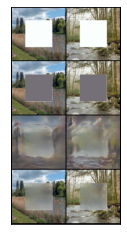

-------------------Test dataset-------------------
	 - Dataset test
	 - Test metrics:
		 Reconstruction loss: 0.9395347833633423
Saving test reconstruction grid to /content/drive/MyDrive/Deep Learning/models/model_photo/test_result-0.6608066135334559.png.


In [ ]:
if __name__ == '__main__':
    if not args.only_evaluate:
        augment()
        save_path = get_save_path()
        initialize_logger(save_path)
        seed_arg = seed(args.random_seed, args.seed)
        logger.info("Seed is set to {}".format(seed_arg))
        writer = SummaryWriter(save_path)
        initial_indices = None
        transform_dict = get_transform_dict(args)
        train_set, validation_set, test_set = get_datasets(
            args.data_dir,
            args.dataset,
            args.num_validation,
            args.is_pct,
            transform_dict["train"],
            transform_dict["test"],
            dataset_indices=initial_indices
        )
        save_dataset_indices(save_path, train_set, validation_set)
        args.iters_per_epoch = (len(train_set) // args.batch_size) + 1
        train_loader, validation_loader, test_loader = create_loaders(
            args,
            train_set,
            validation_set,
            test_set,
            args.batch_size,
            total_iters=args.iters_per_epoch,
            num_workers=args.num_workers
        )
        logger.info("\t- Train set size: {}".format(len(train_set)))
        logger.info("\t- Validation/Test set size: {}".format(len(test_set)))
        train(
            args,
            train_loader,
            validation_loader,
            test_loader,
            writer,
            save_path=save_path
        )
        save_args(args, save_path)
    else:
        _, test_set = get_base_sets(args.dataset, args.data_dir, test_transform=get_normalizer(args.dataset))
        test_loader = DataLoader(
            test_set,
            batch_size=args.batch_size,
            num_workers=args.num_workers,
            shuffle=False,
            pin_memory=args.pin_memory,
        )
        if args.random_masking:
            out_size = args.image_size
        else:
            out_size = args.mask_size
        generator = MODEL_GETTERS["context_generator"](
            bottleneck_dim=args.bottleneck, img_size=args.image_size, out_size=out_size
        )
        checkpoint_file = next(filter(lambda x: x.endswith('.tar'), sorted(os.listdir(args.best_model_path), reverse=True)))
        saved_state = load_state(os.path.join(args.best_model_path, checkpoint_file), map_location=args.device)
        generator.load_state_dict(saved_state['generator_state_dict'])
        random_pattern = generate_random_pattern(args.mask_area, args.resolution, args.max_pattern_size)
        lossG_recon, recon_grid = evaluate(
            args,
            test_loader,
            generator,
            args.mask_size,
            args.overlap,
            random_pattern,
            weighted_mse_loss,
            saved_state['epoch']
        )
        grid_save_path = os.path.join(args.best_model_path, f"test_result-{random.random()}.png")
        print('Test dataset'.center(50, '-'))
        print(f'\t - Dataset {args.dataset}')
        print(f'\t - Test metrics:')
        print(f'\t\t Reconstruction loss: {lossG_recon}')
        print(f'Saving test reconstruction grid to {grid_save_path}.')
        save_image(recon_grid, grid_save_path)
